# Imports

In [1]:
import os # Interact with os functions
import numpy as np # Numerical computations
import tensorflow as tf # The Deep Learning Framework the script will use
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt # For creating visualizations
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # For computing and displaying the confusion matrix
# VGG16 will be used for transfer learning
from tensorflow.keras.applications import VGG16

2024-07-27 13:51:46.117314: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-27 13:51:46.117414: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-27 13:51:46.252136: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Parameters

In [2]:
img_width, img_height = 224, 224 # Dimensions to which images will be resized
batch_size = 32 # Number of samples processed before the internal state of the model is updated
epochs = 100 # Number of times the training dataset gets passed through
num_classes = 4 # Number of output classes (in the case of this project, there are 4 emotions)
supported_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp'] # List of accepted image file extensions
data_dir = '/kaggle/input/dog-emotion/Dog Emotion/' # Path to the folder containing the dataset

# Filtering supported files
Function to filter all the image files with supported file extensions:

In [3]:
def filter_supported_files(filenames):
    return [filename for filename in filenames if os.path.splitext(filename)[1].lower() in supported_extensions]

# Listing subfolders and image files

In [4]:
# Get the list of subfolders (4 classifications/categories) in the dataset folder
subfolders = [folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))]

# Get the image files from the subfolders, collects all images in subdirectories, filtering by supported extensions
image_files = []
for folder in subfolders:
    folder_path = os.path.join(data_dir, folder)
    file_list = os.listdir(folder_path)
    image_files.extend([(folder, filename) for filename in filter_supported_files(file_list)])
    
# Shuffle the list of the supported image files to ensure random distribution
np.random.shuffle(image_files)

# Creating TensorFlow dataset

In [5]:
data = [] # This will store the list of tuples containing image arrays and their corresponding integer labels (folder indexes)
for folder, filename in image_files:
    img_path = os.path.join(data_dir, folder, filename)
    # Loads image and resizes it
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_width, img_height))
    # img_to_array: converts the image to a numpy array
    # Scales pixel values to [0, 1] range
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    # Assign integer label to each class and append the image-data + label to the data-array
    label = subfolders.index(folder)
    data.append((img_array, label))
    
# Shuffle the dataset
# np.random.shuffle(data)

# Splitting the data
Split the Data to 75% training data, 15% validation data and 10% testing data.

In [6]:
train_size = int(len(data) * 0.75)
val_size = int(len(data) * 0.15)
test_size = len(data) - train_size - val_size

# Creating TensorFlow datasets for training, validation, and testing
- tf.data.Dataset.from_generator: creates a TensorFlow dataset from a generator
- output_signature: Specifies the shape and type of the data
- batch(batch_size): Combines elements into batches
- repeat(): Repeats the dataset indefinitely to ensure there is enough data for the training set and validation set (training was sometimes interrupted because there was to little data).

In [7]:
# Training set
training_set = tf.data.Dataset.from_generator(
    lambda: ((x, y) for x, y in data[:train_size]),
    output_signature=(
        tf.TensorSpec(shape=(img_width, img_height, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
).batch(batch_size).repeat()

# Validation set
validation_set = tf.data.Dataset.from_generator(
    lambda: ((x, y) for x, y in data[train_size:train_size+val_size]),
    output_signature=(
        tf.TensorSpec(shape=(img_width, img_height, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
).batch(batch_size).repeat()

# Testing set
testing_set = tf.data.Dataset.from_generator(
    lambda: ((x, y) for x, y in data[train_size+val_size:]),
    output_signature=(
        tf.TensorSpec(shape=(img_width, img_height, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
).batch(batch_size)

# Visualize a sample of the dataset
Displays a few images with their labels.

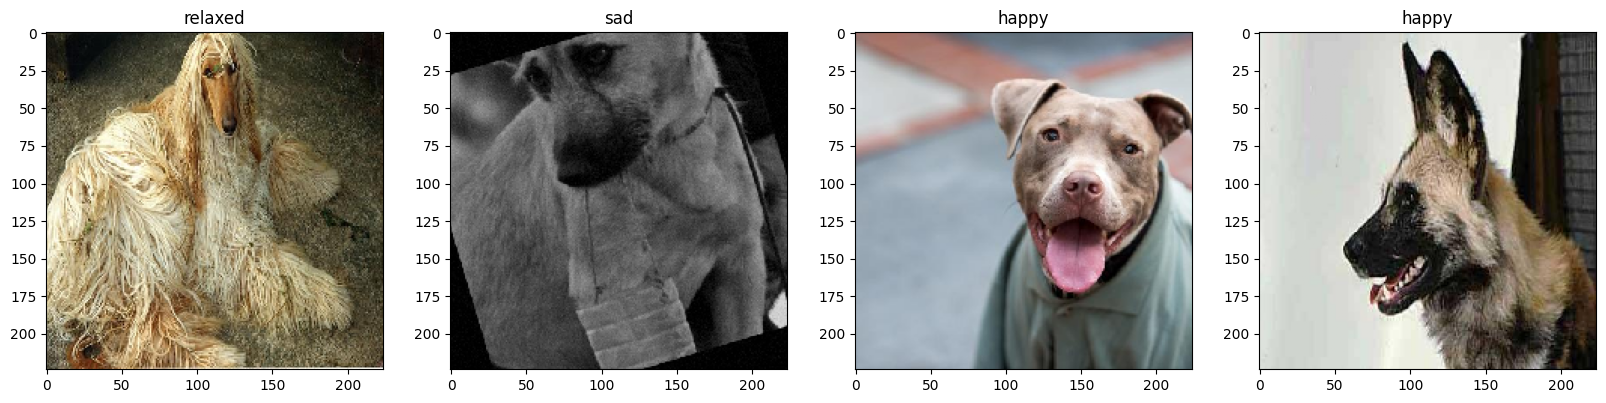

In [8]:
batch = next(iter(training_set))
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, (img, label) in enumerate(zip(batch[0][:4], batch[1][:4])):
    ax[idx].imshow(img)
    ax[idx].title.set_text(subfolders[label.numpy()])
plt.show()

# Data augmentation
Applies random transformations to images to enhance the model's generalization ability.

In [9]:
data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

# Define the training dataset with augmentation
training_set = training_set.map(lambda x, y: (data_augmentation(x), y))

# Build Fine-tuned model (VGG16)
First the model needs to be downloaded:

In [10]:
vgg16_model = VGG16(weights='imagenet')
vgg16_model.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

# Build a new model
A new model is built and it gets all the layers of the vgg16 model added to it (without the predictions/output layers).  
All the layers need to be frozen (layers must be set to not be trainable), to prevent retraining them.

In [11]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    layer.trainable = False
    model.add(layer)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 134,260,544 (512.16 MB)

# Adding a new output layer

In [12]:
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │        16,388 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,276,932 (512.23 MB)

 Trainable params: 16,388 (64.02 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

# Compile the model
- optimizer: Adam optimizer.
- loss: Categorical cross-entropy loss function.
- metrics: Metrics to evaluate during training and testing (accuracy).

In [13]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary();

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │        16,388 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,276,932 (512.23 MB)

 Trainable params: 16,388 (64.02 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

# Train the model
- steps_per_epoch: Number of steps (batches of samples) to yield from the dataset before declaring one epoch finished.
- validation_steps: Number of steps to evaluate during validation at the end of each epoch.
- model.fit: Trains the model for a fixed number of epochs.

In [14]:
steps_per_epoch = train_size // batch_size
validation_steps = val_size // batch_size

history = model.fit(
    training_set,
    epochs=epochs,
    validation_data=validation_set,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

Epoch 1/100


2024-07-27 13:52:30.622682: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2024-07-27 13:52:30.622735: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2024-07-27 13:52:30.622744: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2024-07-27 13:52:30.622752: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2024-07-27 13:52:30.622760: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.25159, expected 5.47629
2024-07-27 13:52:30.622768: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.43964, expected 4.66434
2024-07-27 13:52:30.622776: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.54333, expected 5.76803
2024-07-27 13:52:30.622783: E external/local_xla/xla/se

 2/93 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.2500 - loss: 1.6270  

I0000 00:00:1722088366.361201      69 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722088366.385610      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.2584 - loss: 1.4279

W0000 00:00:1722088400.977419      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


93/93 ━━━━━━━━━━━━━━━━━━━━ 55s 388ms/step - accuracy: 0.2586 - loss: 1.4276 - val_accuracy: 0.3073 - val_loss: 1.3696
Epoch 2/100


2024-07-27 13:53:22.992105: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50188: 2.79675, expected 2.40555
2024-07-27 13:53:22.992165: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50357: 2.77153, expected 2.38033
2024-07-27 13:53:22.992174: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50399: 2.10715, expected 1.71595
2024-07-27 13:53:22.992202: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 55327: 2.85302, expected 2.46182
2024-07-27 13:53:22.993047: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 200704: 4.41732, expected 3.71194
2024-07-27 13:53:22.993079: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 200705: 5.86452, expected 5.15914
2024-07-27 13:53:22.993089: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 200706: 5.41314, expected 4.70776
2024-07-27 13:53:22.9930

 3/93 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.2736 - loss: 1.3802

W0000 00:00:1722088415.148927      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.3316 - loss: 1.3485

W0000 00:00:1722088449.166793      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


93/93 ━━━━━━━━━━━━━━━━━━━━ 48s 382ms/step - accuracy: 0.3317 - loss: 1.3484 - val_accuracy: 0.3574 - val_loss: 1.3135
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.3500 - loss: 1.3208 - val_accuracy: 0.3979 - val_loss: 1.2774
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 34s 372ms/step - accuracy: 0.3624 - loss: 1.3071 - val_accuracy: 0.4296 - val_loss: 1.2398
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 34s 371ms/step - accuracy: 0.3922 - loss: 1.2876 - val_accuracy: 0.4366 - val_loss: 1.2329
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 34s 373ms/step - accuracy: 0.4254 - loss: 1.2664 - val_accuracy: 0.4401 - val_loss: 1.2134
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 34s 374ms/step - accuracy: 0.4398 - loss: 1.2462 - val_accuracy: 0.4595 - val_loss: 1.1941
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 35s 382ms/step - accuracy: 0.4389 - loss: 1.2459 - val_accuracy: 0.4507 - val_loss: 1.1893
Epoch 9/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 386ms/step - accuracy: 0.4362 - loss: 1.2448 - val_accuracy

# Evaluating the model on testing set
- test_steps: Number of steps to evaluate during testing.
- model.evaluate: Evaluates the model on the testing dataset.

In [15]:
test_steps = test_size // batch_size

test_loss, test_accuracy = model.evaluate(testing_set, steps=test_steps)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.4762 - loss: 1.1078
Test Loss: 1.1045595407485962, Test Accuracy: 0.484375


# Plot training and validation metrics
Displays training and validation accuracy and loss over epochs.

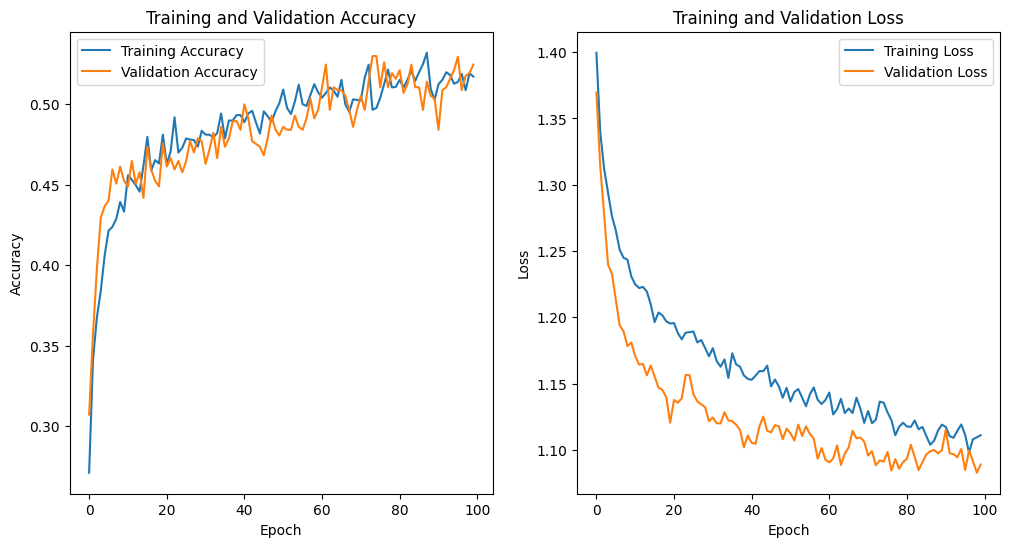

In [16]:
# Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Making predictions on the test set

In [17]:
test_images = []
test_labels = []
for img, label in testing_set.unbatch().take(test_size):
    test_images.append(img.numpy())
    test_labels.append(label.numpy())

test_images = np.array(test_images)
test_labels = np.array(test_labels)

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

 4/13 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

W0000 00:00:1722091847.591457      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

2024-07-27 14:50:48.956728: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.89842, expected 3.37692
2024-07-27 14:50:48.956792: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.13412, expected 2.61262
2024-07-27 14:50:48.956802: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 3.08377, expected 2.56227
2024-07-27 14:50:48.956810: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 14: 4.1021, expected 3.5806
2024-07-27 14:50:48.956818: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 3.76539, expected 3.24388
2024-07-27 14:50:48.956826: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30: 4.19841, expected 3.6769
2024-07-27 14:50:48.956834: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 63: 3.88366, expected 3.36216
2024-07-27 14:50:48.956841: E external/local_xla/xla

13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 824ms/step


W0000 00:00:1722091857.484040      68 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


# Computing and plotting the confusion matrix

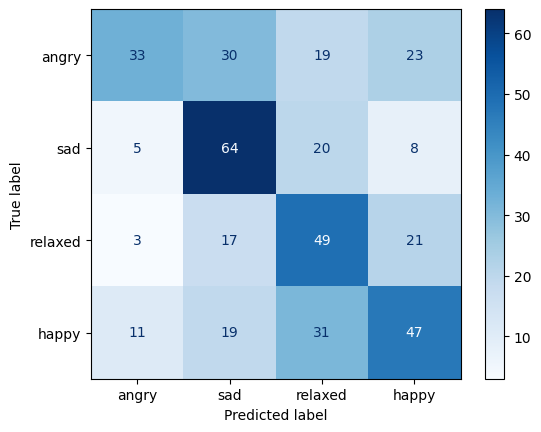

In [18]:
conf_matrix = confusion_matrix(test_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=subfolders)
disp.plot(cmap=plt.cm.Blues)
plt.show()